# Machine Learning e Imágenes en Python

### Clasificación dentro de una imagen: 4 clases, 3 variables o features: R,G,B

Cargue una imagen RGB a elección que a la vista tenga 4 clases identificables:

* Describa con sus palabras brevemente las 4 clases que ve en la imagen.
* Utilice k-medias con k=4 cantidad de clusters para realizar clasificación no supervisada de la imagen. Muestre los resultados, tanto en el espacio RGB como en la disposición de los clusters encontrados en la imagen.
* Realice una clasificación semi-supervisada: 
 - Etiquetando manualmente pixeles de las 4 clases. Muestre los pixeles etiquetados en el espacio RGB. 
 - Reclasificando toda la imagen según esas cuatro clases.
 - Muestre los resultados y realice una mejora de la clasificación utilizando un filtro de moda
 * Comente los resultados. 
 
 Ayuda: Utilice la distancia euclídea. Normalice las observaciones si lo requiere su conjunto de datos ("distancia del coseno") 

Imagen elegida:


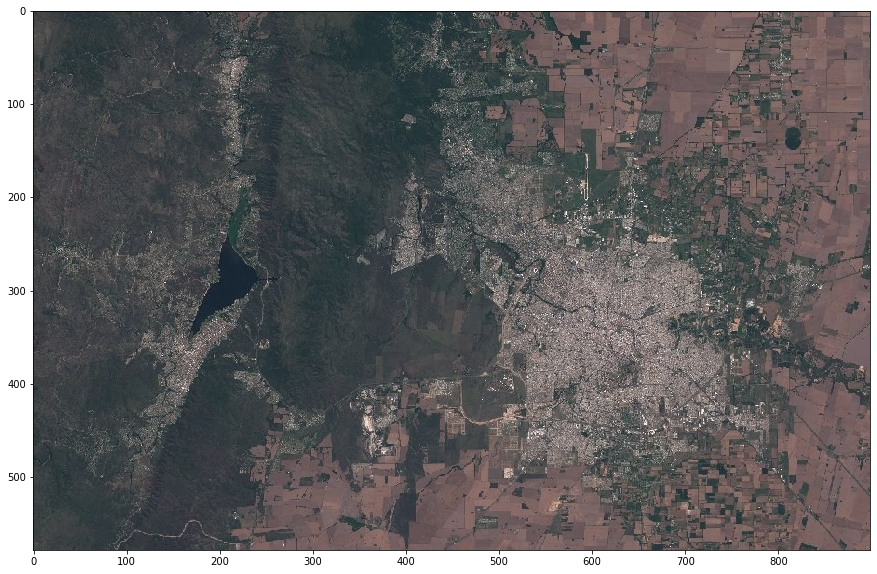

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import pandas as pd

# Cargo y grafico imagen RGB
satelital_cv=cv2.imread('Sentinel-2 L1C, True color on 2020-12-10.jpg')
satelital=satelital_cv.copy()
satelital[:,:,[2,1,0]]=satelital_cv #De BGR a RGB

print('Imagen elegida:')
plt.figure(figsize=(15,10))
plt.imshow(satelital)
plt.show()

In [4]:
# Paso la base de pixeles a Data Frame
dims=satelital.shape
cant_filas=dims[0]
cant_columnas=dims[1]
cant_pixeles=cant_filas*cant_columnas
data0=np.zeros([cant_pixeles,4],dtype='int')
for f in range(cant_filas):
    for c in range(cant_columnas):
        nro=f*cant_columnas+c
        data0[nro,0]=nro
        data0[nro,1:4]=satelital[f,c,:]

df = pd.DataFrame(data0, columns=["pixel_id","rojo","verde","azul"])

print('CLASES')
print('Las 4 clases que identifico en la imagen son: la zona "verde" de vegetación, la "azul" del lago, la "blanca" de la zona urbana y la "marrón" de la zona sembrada.')
print('')

# Muestro el Data Frame
print('Base de pixeles:')
df.head()

CLASES
Las 4 clases que identifico en la imagen son: la zona "verde" de vegetación, la "azul" del lago, la "blanca" de la zona urbana y la "marrón" de la zona sembrada.

Base de pixeles:


,pixel_id,rojo,verde,azul
0,0,57,61,64
1,1,60,64,67
2,2,60,61,65
3,3,74,75,79
4,4,68,68,70


In [5]:
# Arrancamos con Clustering
# Librerías para Clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# Quito la columna del pixel id
df_pix=df.drop('pixel_id',axis=1)

# Distancia del coseno (normalizo los vectores)
normalized_vectors = preprocessing.normalize(df_pix)

# Se agrupan los datos usando Kmedias en 4 clusters
normalized_kmeans = KMeans(n_clusters=4)
normalized_kmeans.fit(normalized_vectors) #Con los vectores normalizados RGB te predice la clase
df_clusters=df.copy() #Copio el df original
df_clusters['kmedias_cos_4']=normalized_kmeans.labels_ #Le agrego una columna con los labels de la clase
print('CLASIFIACIÓN NO SUPERVISADA')
print('')
print('Base con etiquetas de clases:')
df_clusters.head()

CLASIFIACIÓN NO SUPERVISADA

Base con etiquetas de clases:


,pixel_id,rojo,verde,azul,kmedias_cos_4
0,0,57,61,64,3
1,1,60,64,67,3
2,2,60,61,65,3
3,3,74,75,79,3
4,4,68,68,70,0



Visualización de clusters en espacio RGB:


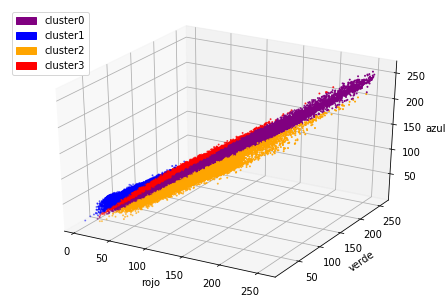


Visualización en la imagen:


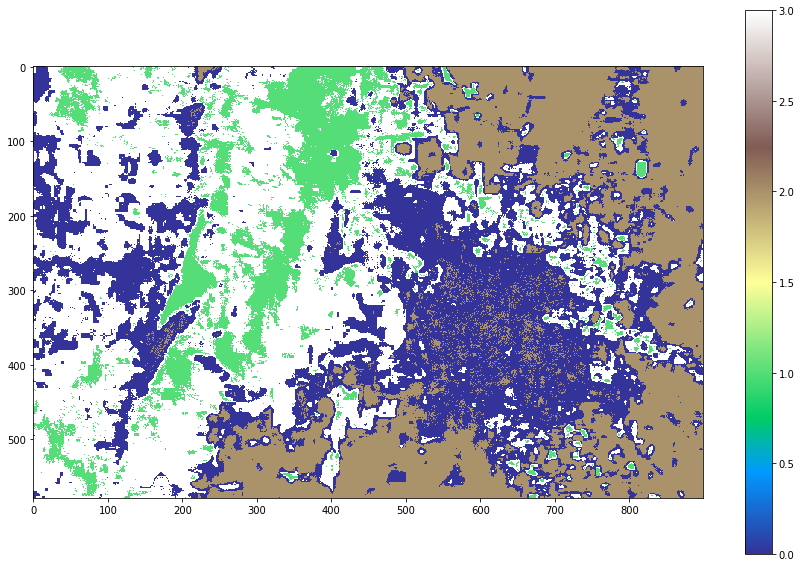

In [6]:
# Se le asignan colores a cada categoría para poder graficar
colores=['purple','blue','orange','red']
variables=["rojo","verde","azul"]

f3 = df_clusters.kmedias_cos_4 #En f3 guardamos todas las etiquetas (labels)

asignar=[] #En asignar se generará una lista con los colores de cada pixel
l=len(f3)

for k in range(l):
    asignar.append(colores[f3[k]])
    
# Visualización en el espacio RGB
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

print('')
print('Visualización de clusters en espacio RGB:')

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df[variables[0]].values, df[variables[1]].values, df[variables[2]].values,c=asignar, s=1)
ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])
patch1 = mpatches.Patch(color=colores[0], label='cluster0')
patch2 = mpatches.Patch(color=colores[1], label='cluster1')
patch3 = mpatches.Patch(color=colores[2], label='cluster2')
patch4 = mpatches.Patch(color=colores[3], label='cluster3')
plt.legend(handles=[patch1,patch2,patch3,patch4])
plt.show()

# Visualización en la imagen
print('')
print('Visualización en la imagen:')

clasif=df_clusters.kmedias_cos_4.values.reshape(satelital.shape[0],satelital.shape[1])

plt.figure(figsize=(15,10))
plt.imshow(clasif,cmap='terrain')
plt.colorbar()
plt.show()

In [7]:
# Ahora vamos con la Clasifiación Semi-supervisada
print('CLASIFIACIÓN SEMI SUPERVISADA')
print('')

# Elegimos las 4 regiones de interés (ROI)
print('Determinamos las regiones de interés')
print('')
print('En cada ROI se guardará: (columna, fila, anchocol, anchofila)')
print('')

showCrosshair = False
fromCenter = False

# Lago
roi1 = cv2.selectROI("Delimite la ROI del lago con mouse + ent + tecla", satelital_cv, fromCenter, showCrosshair)
cv2.waitKey() #espera pulsado de tecla
print('Región de lago')
print('ROI1:',roi1)
print('')
cv2.destroyAllWindows()

# Vegetación verde
roi2 = cv2.selectROI("Delimite la ROI de la vegetación verde con mouse + ent + tecla", satelital_cv, fromCenter, showCrosshair)
cv2.waitKey() #espera pulsado de tecla
print('Región de vegetación verde')
print('ROI2:',roi2)
print('')
cv2.destroyAllWindows()

# Campos
roi3 = cv2.selectROI("Delimite la ROI de los campos con mouse + ent + tecla", satelital_cv, fromCenter, showCrosshair)
cv2.waitKey() #espera pulsado de tecla
print('Región de campos')
print('ROI3:',roi3)
print('')
cv2.destroyAllWindows()

# Ciudad
roi4 = cv2.selectROI("Delimite la ROI de la ciudad con mouse + ent + tecla", satelital_cv, fromCenter, showCrosshair)
cv2.waitKey() #espera pulsado de tecla
print('Región urbana')
print('ROI4:',roi4)
cv2.destroyAllWindows()

CLASIFIACIÓN SEMI SUPERVISADA

Determinamos las regiones de interés

En cada ROI se guardará: (columna, fila, anchocol, anchofila)

Región de lago
ROI1: (207, 278, 21, 19)

Región de vegetación verde
ROI2: (279, 31, 54, 371)

Región de campos
ROI3: (627, 18, 120, 92)

Región urbana
ROI4: (567, 282, 77, 91)


In [30]:
###BlOQUE OPCIONAL!
#Este bloque invalida al anterior, ejecutarlo si se desea utilizar las ROI ya determinados manualmente.

roi1=(205, 275, 25, 29) #lago
roi2=(273, 286, 180, 104) #vegetación verde
roi3=(638, 7, 257, 159) #campos
roi4=(565, 283, 132, 143) #ciudad

print('En cada ROI se guardará: (columna, fila, anchocol, anchofila)')
print('')
print('Región de lago')
print('ROI1:',roi1)
print('')
print('Región de vegetación verde')
print('ROI2:',roi2)
print('')
print('Región de campos')
print('ROI3:',roi3)
print('')
print('Región urbana')
print('ROI4:',roi4)

En cada ROI se guardará: (columna, fila, anchocol, anchofila)

Región de lago
ROI1: (205, 275, 25, 29)

Región de vegetación verde
ROI2: (273, 286, 180, 104)

Región de campos
ROI3: (638, 7, 257, 159)

Región urbana
ROI4: (565, 283, 132, 143)


In [8]:
#Construyo el dataset con las etiquetas de las ROI elegidas
rois=[roi1,roi2,roi3,roi4]

cantidad=0
for i in range(4):
    cantidad=cantidad+(rois[i][2]*rois[i][3]) #Con este ciclo calculo cantidad de pixeles (columna * filas)
print('Cantidad de datos etiquetados:',cantidad)
print('Cantidad de clases:',4)
print('')

data=np.zeros([cantidad,5],dtype='int')
target=np.zeros(cantidad,dtype='int')
cuenta=0
for i in range(4):
    roi=rois[i]
    
    for fil in range (roi[1],roi[1]+roi[3]): #Desde (Fila) hasta (Fila + ancho de filas)
        for col in range (roi[0],roi[0]+roi[2]): #Desde (Columna) hasta (Columna + ancho de columnas)
            nro=fil*cant_columnas+col #Para obtener número del pixel (fila atual por columnas + columna actual)
            data[cuenta,0]=nro #Guardo número del pixel
            data[cuenta,1:4]=satelital[fil,col,:] #Guardo valores R,G,B
            data[cuenta,4]=i+1 #Guardo número de la RO1 (etiqueta)
            target[cuenta]=i+1
            cuenta=cuenta+1

df_etiquetado = pd.DataFrame(data, columns=["pixel_id","rojo","verde","azul","etiqueta"])
print('Base de pixeles etiquetados:')
df_etiquetado.head()

Cantidad de datos etiquetados: 38480
Cantidad de clases: 4

Base de pixeles etiquetados:


,pixel_id,rojo,verde,azul,etiqueta
0,250129,24,40,53,1
1,250130,24,38,51,1
2,250131,24,38,51,1
3,250132,24,38,51,1
4,250133,24,38,51,1


Visualización de datos etiquetados en espacio RGB:


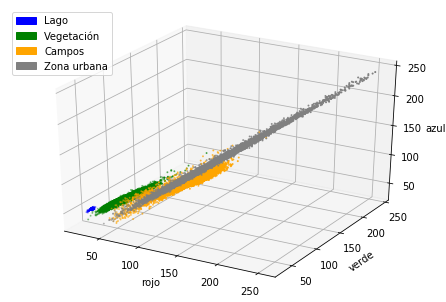

In [9]:
# Se le asignan colores a cada categoría para poder graficar
colores=['blue','green','orange','grey']
variables=["rojo","verde","azul"]

asignar2=[] #En asignar se generará una lista con los colores de cada pixel
l=len(target)

for k in range(l):
    asignar2.append(colores[target[k]-1])

# Visualización en el espacio RGB
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

print('Visualización de datos etiquetados en espacio RGB:')

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_etiquetado[variables[0]].values, df_etiquetado[variables[1]].values, df_etiquetado[variables[2]].values,c=asignar2, s=1)
ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])
patch1 = mpatches.Patch(color=colores[0], label='Lago')
patch2 = mpatches.Patch(color=colores[1], label='Vegetación')
patch3 = mpatches.Patch(color=colores[2], label='Campos')
patch4 = mpatches.Patch(color=colores[3], label='Zona urbana')
plt.legend(handles=[patch1,patch2,patch3,patch4])
plt.show()

Resultado de la clasifiación de todos los datos en la imagen:


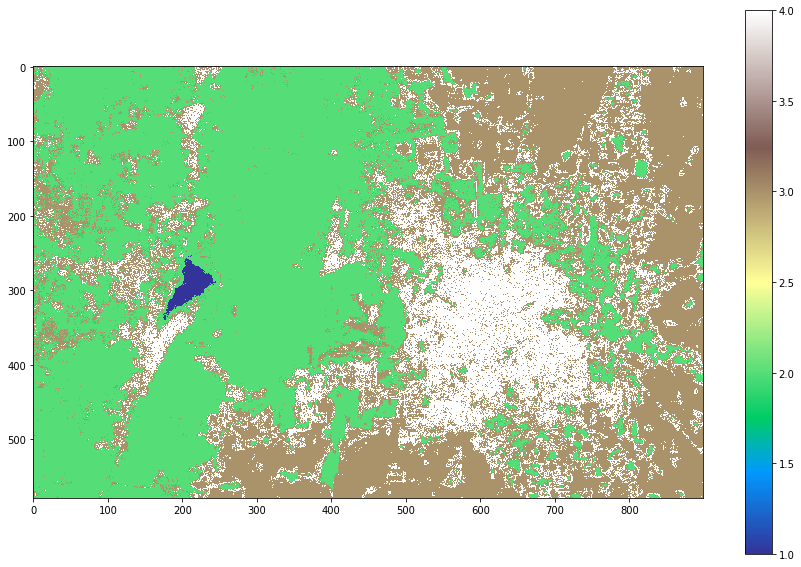

In [10]:
# Clasificamos la imagen completa: Se clasifican todos los datos usando el modelo entrenado
from sklearn.neighbors import KNeighborsClassifier

print('Resultado de la clasifiación de todos los datos en la imagen:')

n_neighbors = 1
data_rgb=data[:,1:4]

knn = KNeighborsClassifier(n_neighbors) #Con k=1 vecinos
knn.fit(data_rgb, target) #Entreno el modelo con los datos ya etiquetados

a=satelital.shape
clasif2=np.zeros(a[0:2],dtype='int') #Creamos una matriz vacía de iguales dimensiones (filas y columnas) que la original

for i in range(a[0]): #filas
    for j in range(a[1]): #columnas
        clasif2[i,j]=knn.predict([satelital[i,j,:]]) #Predigo las etiquetas para todos los valores RGB

# Grafico
plt.figure(figsize=(15,10))
plt.imshow(clasif2,cmap='terrain')
plt.colorbar()
plt.show()

Mejora de la clasifiación aplicando un filtro de moda:


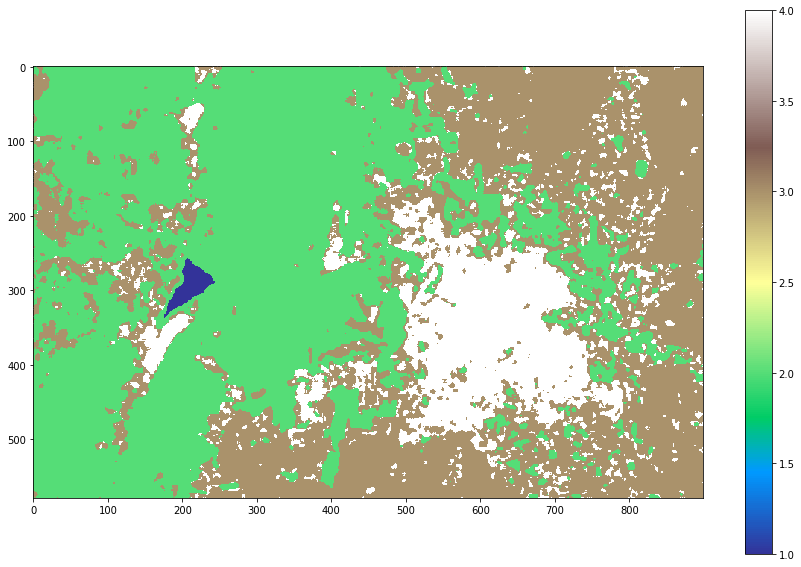

Comparación de resultados:



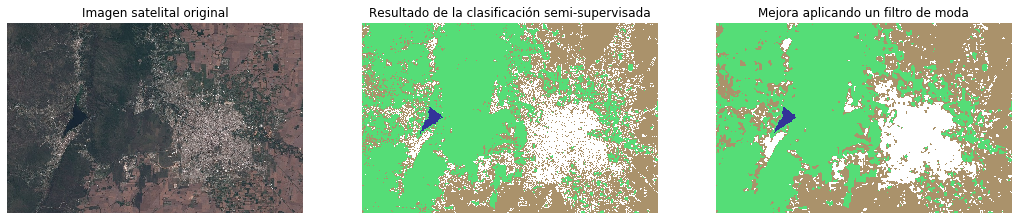

Comentarios: En la calsificación semi-supervisada podemos ver algunas mejoras con respecto a la calsifiación no-supervisada, la cual presentaba aglunos errores principalmente en el etiquetado de datos pertenecientes a la zona del lago y la vegetación. La clasifiación semi-supervisada nos da un resultado mucho más preciso con respecto al etiquetado de zonas de la imagen original. Finalmente, al aplicar un filtro de moda lo que sucede es que se obtiene una imagen de mayor nitidez, esto puede tener sus pros o contras dependiendo el uso que querramos darle a nuestra imagen, las regiones ahora se encuentran más delimitadas y con menos ruido, por lo que la segmentación de zonas está más definida, sin embargo se pierden algunos datos que podrían ser de utilidad


In [11]:
# Mejora de la clasificación utilizando un filtro de moda
from statistics import mode

clasif3=clasif2.copy()
for i in range(2,a[0]-2): #filas
    for j in range(2,a[1]-2): #columnas
        try:
            clasif3[i,j]=mode(clasif2[i-2:i+3,j-2:j+3].ravel())
        except:
            clasif3[i,j]=clasif2[i,j]

print('Mejora de la clasifiación aplicando un filtro de moda:')

# Grafico la mejora
plt.figure(figsize=(15,10))
plt.imshow(clasif3,cmap='terrain')
plt.colorbar()
plt.show()

# Comparación de los 3 gráficos
print('Comparación de resultados:')
print('')

fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(18)
axs[0].imshow(satelital)
axs[0].set_title("Imagen satelital original")
axs[0].axis('off')
axs[1].imshow(clasif2,cmap='terrain')
axs[1].set_title("Resultado de la clasificación semi-supervisada")
axs[1].axis('off')
axs[2].imshow(clasif3,cmap='terrain')
axs[2].set_title('Mejora aplicando un filtro de moda')
axs[2].axis('off')
plt.show()

print('Comentarios: En la calsificación semi-supervisada podemos ver algunas mejoras con respecto a la calsifiación no-supervisada, la cual presentaba aglunos errores principalmente en el etiquetado de datos pertenecientes a la zona del lago y la vegetación. La clasifiación semi-supervisada nos da un resultado mucho más preciso con respecto al etiquetado de zonas de la imagen original. Finalmente, al aplicar un filtro de moda lo que sucede es que se obtiene una imagen de mayor nitidez, esto puede tener sus pros o contras dependiendo el uso que querramos darle a nuestra imagen, las regiones ahora se encuentran más delimitadas y con menos ruido, por lo que la segmentación de zonas está más definida, sin embargo se pierden algunos datos que podrían ser de utilidad.')